# DC2 Image Analysis, Crab, Image Deconvolution using CDS in the Galactic coordinate system

updated on 2024-01-30 (the commit 26cfdeacb25335bd511a91c4f8a29bdeb36408f2)

This notebook focuses on the image deconvolution with the Compton data space (CDS) in the Galactic coordinate system.
An example of the image analysis will be presented using the the Crab 3-month simulation data created for DC2.

In DC2, we have two options on the coordinate system to describe the Compton scattering direction ($\chi\psi$) in the image deconvolution. Please also check the notes written in Crab-DC2-ScAtt-DataReduction.ipynb.

In [2]:
from histpy import Histogram, HealpixAxis, Axis, Axes
from mhealpy import HealpixMap
from astropy.coordinates import SkyCoord, cartesian_to_spherical, Galactic

from cosipy.response import FullDetectorResponse
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.ts_map.TSMap import TSMap
from cosipy.data_io import UnBinnedData, BinnedData
from cosipy.image_deconvolution import SpacecraftAttitudeExposureTable, CoordsysConversionMatrix, DataLoader, ImageDeconvolution

# cosipy uses astropy units
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
from scoords import Attitude, SpacecraftFrame

#3ML is needed for spectral modeling
from threeML import *
from astromodels import Band

#Other standard libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 

import healpy as hp
from tqdm.autonotebook import tqdm

%matplotlib inline

# 0. Files needed for this notebook

From wasabi
- cosi-pipeline-public/COSI-SMEX/DC2/Responses/PointSourceReponse/psr_gal_continuum_DC2.h5.zip (please unzip it)
    - a pre-computed continuum response file converted into the Galactic coordinate system
- cosi-pipeline-public/COSI-SMEX/DC2/Data/Sources/Crab_DC2_3months_unbinned_data.fits.gz
- cosi-pipeline-public/COSI-SMEX/DC2/Data/Backgrounds/albedo_photons_3months_unbinned_data.fits.gz
    - In this notebook, only the albedo gamma-ray background is considered for a tutorial.
    - If you want to consider all of the background components, please replace it with cosi-pipeline-public/COSI-SMEX/DC2/Data/Backgrounds/total_bg_3months_unbinned_data.fits.gz
    - Note that total_bg_3months_unbinned_data.fits.gz is 14.15 GB.

From docs/tutorials/image_deconvolution/Crab/GalacticCDS
- inputs_Crab_DC2.yaml
- imagedeconvolution_parfile_gal_Crab.yml
- crab_spec.dat

You can download the data and detector response from wasabi. You can skip this cell if you already have downloaded the files.

In [ ]:
import os

header = "AWS_ACCESS_KEY_ID=GBAL6XATQZNRV3GFH9Y4 AWS_SECRET_ACCESS_KEY=GToOczY5hGX3sketNO2fUwiq4DJoewzIgvTCHoOv aws s3api get-object"

os.system(header + " --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Responses/PointSourceReponse/psr_gal_continuum_DC2.h5.zip --endpoint-url=https://s3.us-west-1.wasabisys.com psr_gal_continuum_DC2.h5.zip")

os.system(header + " --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Sources/Crab_DC2_3months_unbinned_data.fits.gz --endpoint-url=https://s3.us-west-1.wasabisys.com Crab_DC2_3months_unbinned_data.fits.gz")

os.system(header + " --bucket cosi-pipeline-public --key COSI-SMEX/DC2/Data/Backgrounds/albedo_photons_3months_unbinned_data.fits.gz --endpoint-url=https://s3.us-west-1.wasabisys.com albedo_photons_3months_unbinned_data.fits.gz")

os.system("unzip psr_gal_continuum_DC2.h5.zip")

# 1. Create binned event/background files in the Galactic coordinate system

<span style="color:red"> please modify "path_data" corresponding to your environment.</span>

In [3]:
path_data = "path/to/data/"

**Source**

In [4]:
%%time

signal_filepath = path_data + "Crab_DC2_3months_unbinned_data.fits.gz"

binned_signal = BinnedData(input_yaml = "inputs_Crab_DC2.yaml")

binned_signal.get_binned_data(unbinned_data = signal_filepath, psichi_binning="galactic")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None
CPU times: user 15.9 s, sys: 528 ms, total: 16.4 s
Wall time: 16.6 s


**Background**

In [5]:
%%time

bkg_filepath = path_data + "albedo_photons_3months_unbinned_data.fits.gz"

binned_bkg = BinnedData(input_yaml = "inputs_Crab_DC2.yaml")

binned_bkg.get_binned_data(unbinned_data = bkg_filepath, psichi_binning="galactic")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None
CPU times: user 1min 49s, sys: 3.88 s, total: 1min 53s
Wall time: 1min 54s


Convert the data into sparse matrices & add the signal to the background

In [6]:
signal = binned_signal.binned_data.to_dense()
bkg = binned_bkg.binned_data.to_dense()
event = signal + bkg

Save the binned histograms

In [7]:
signal.write("crab_dc2_galactic_signal.hdf5", overwrite = True)
bkg.write("crab_dc2_galactic_bkg.hdf5", overwrite = True)
event.write("crab_dc2_galactic_event.hdf5", overwrite = True)

Load the saved files

In [8]:
signal = Histogram.open("crab_dc2_galactic_signal.hdf5")
bkg = Histogram.open("crab_dc2_galactic_bkg.hdf5")
event = Histogram.open("crab_dc2_galactic_event.hdf5")

In DC2, the number of time bins should be 1 when you perform the image deconvolution using the galactic CDS.
It is because the pre-computed response files in the galactic coordinate have no time axis, and all of the events are assumed to be projected into a single galactic CDS.
In the future, we plan to introduce more flexible binning.

In [9]:
bkg.axes['Time'].edges

<Quantity [1.83548730e+09, 1.84346726e+09] s>

# 2. Load the response matrix

In [10]:
%%time

response_path = path_data + "psr_gal_continuum_DC2.h5"

image_response = Histogram.open(response_path)

CPU times: user 2.24 s, sys: 17.7 s, total: 19.9 s
Wall time: 29.7 s


In [11]:
image_response.axes.labels

array(['NuLambda', 'Ei', 'Em', 'Phi', 'PsiChi'], dtype='<U8')

In [12]:
image_response.contents.shape

(768, 10, 10, 36, 768)

# 3. Prepare a 'fake' coordsys conversion matrix

The coordsys conversion matrix was initially introduced to convert a model map in the Galactic coordinates into the local coordinates.
In the case of this notebook, the CDS is in the Galactic coordinates; thus, ideally, we do not have to convert the coordinates of the model map.
However, as for now, the code for the image deconvolution was mainly developed for the CDS in the local coordinates and requires the conversion matrix, so here, we generate a ‘fake’ coordinate conversion matrix, which is an unit matrix. 
Then, the same code can be applied for both methods. 
We will consider removing this fake coordinate conversion matrix in the future.

In [13]:
nside = image_response.axes['NuLambda'].nside
nside

8

In [15]:
axes = [event.axes['Time'],
        HealpixAxis(nside = nside, coordsys = "galactic", label = "lb"), 
        HealpixAxis(nside = nside, coordsys = "galactic", label = "NuLambda")]

ccm = CoordsysConversionMatrix(axes, binning_method = 'Time', unit = u.dimensionless_unscaled, sparse = True)

for ipix in range(axes[1].npix):
    ccm[:,ipix,ipix] = 1 * u.dimensionless_unscaled

In [16]:
ccm.contents

Format,coo
Data Type,float64
Shape,"(1, 768, 768)"
nnz,768
Density,0.0013020833333333333
Read-only,True
Size,24.0K
Storage ratio,0.0


# 4. Imaging deconvolution

## Brief overview of the image deconvolution

Basically, we have to maximize the following likelihood function

$$
\log L = \sum_i X_i \log \epsilon_i - \sum_i \epsilon_i
$$

$X_i$: detected counts at $i$-th bin ( $i$ : index of the Compton Data Space)

$\epsilon_i = \sum_j R_{ij} \lambda_j + b_i$ : expected counts ( $j$ : index of the model space)

$\lambda_j$ : the model map (basically gamma-ray flux at $j$-th pixel)

$b_i$ : the background at $i$-th bin

$R_{ij}$ : the response matrix

Since we have to optimize the flux in each pixel, and the number of parameters is large, we adopt an iterative approach to find a solution of the above equation. The simplest one is the ML-EM (Maximum Likelihood Expectation Maximization) algorithm. It is also known as the Richardson-Lucy algorithm.

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \delta \lambda_{j}^{k}
$$
$$
\delta \lambda_{j}^{k} = \frac{\lambda_{j}^{k}}{\sum_{i} R_{ij}} \sum_{i} \left(\frac{ X_{i} }{\epsilon_{i}} - 1 \right) R_{ij} 
$$

We refer to $\delta \lambda_{j}^{k}$ as the delta map.

As for now, the two improved algorithms are implemented in COSIpy.

- Accelerated ML-EM algorithm (Knoedlseder+99)

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \alpha^{k} \delta \lambda_{j}^{k}
$$
$$
\alpha^{k} < \mathrm{max}(- \lambda_{j}^{k} / \delta \lambda_{j}^{k})
$$

Practically, in order not to accelerate the algorithm excessively, we set the maximum value of $\alpha$ ($\alpha_{\mathrm{max}}$). Then, $\alpha$ is calculated as:

$$
\alpha^{k} = \mathrm{min}(\mathrm{max}(- \lambda_{j}^{k} / \delta \lambda_{j}^{k}), \alpha_{\mathrm{max}})
$$

- Noise damping using gaussian smoothing (Knoedlseder+05, Siegert+20)

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \alpha^{k} \left[ w_j \delta \lambda_{j}^{k} \right]_{\mathrm{gauss}}
$$
$$
w_j = \left(\sum_{i} R_{ij}\right)^\beta
$$

$\left[ ... \right]_{\mathrm{gauss}}$ means that the differential image is smoothed by a gaussian filter.

## 4-1. Prepare DataLoader containing all neccesary datasets

In [17]:
dataloader = DataLoader()

dataloader.event_dense = event
dataloader.bkg_dense = bkg

# the loaded response matrix should be assigned to both full_detector_response/image_response_dense in the Galactic CDS method.
dataloader.full_detector_response = image_response
dataloader.image_response_dense = image_response 

dataloader.response_on_memory = True
dataloader.coordsys_conv_matrix = ccm

In [18]:
dataloader._modify_axes()

... checking the axis Time of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Em of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Phi of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis PsiChi of the event and background files...
    --> pass (edges)
    --> pass (unit)
...checking the axis Em of the event and response files...
    --> pass (edges)
...checking the axis Phi of the event and response files...
    --> pass (edges)
...checking the axis PsiChi of the event and response files...
    --> pass (edges)
The axes in the event and background files are redefined. Now they are consistent with those of the response file.



WARNING FutureWarning: Note that _modify_axes() in DataLoader was implemented for a temporary use. It will be removed in the future.


WARNING UserWarning: Make sure to perform _modify_axes() only once after the data are loaded.



(In the future, we plan to remove the method "_modify_axes.")

Here, we calculate an auxiliary matrix for the deconvolution. Basically, it is a response matrix projected into the model space ($\sum_{i} R_{ij}$). Currently, it is mandatory to run this command for the image deconvolution.

In [19]:
%%time

dataloader.calc_image_response_projected()

... (DataLoader) calculating a projected image response ...
CPU times: user 1.38 s, sys: 1.65 s, total: 3.03 s
Wall time: 3.09 s


## 4-3. Initialize the instance of the image deconvolution class

First, we prepare an instance of the ImageDeconvolution class and then register the dataset and parameters for the deconvolution. After that, you can start the calculation.

<span style="color:red"> please modify this parameter_filepath corresponding to your environment.</span>

In [20]:
parameter_filepath = "imagedeconvolution_parfile_gal_Crab.yml"

In [21]:
image_deconvolution = ImageDeconvolution()

# set dataloader to image_deconvolution
image_deconvolution.set_data(dataloader)

# set a parameter file for the image deconvolution
image_deconvolution.read_parameterfile(parameter_filepath)

data for image deconvolution was set ->  <cosipy.image_deconvolution.data_loader.DataLoader object at 0x2da0f7eb0>
parameter file for image deconvolution was set ->  imagedeconvolution_parfile_gal_Crab.yml


### Initialize image_deconvolution

In this process, a model map is defined following the input parameters, and it is initialized. Also, it prepares ancillary data for the image deconvolution, e.g., the expected counts with the initial model map, gaussian smoothing filter etc.

I describe parameters in the parameter file.

#### model_property

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
| coordinate | str | the coordinate system of the model map | As for now, it must be 'galactic' |
| nside | int | NSIDE of the model map | it must be the same as NSIDE of 'lb' axis of the coordinate conversion matrix|
| scheme | str | SCHEME of the model map | As for now, it must be 'ring' |
| energy_edges | list of float [keV] | The definition of the energy bins of the model map | As for now, it must be the same as that of the response matrix |

#### model_initialization

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
| algorithm | str | the method name to initialize the model map | As for now, only 'flat' can be used |
| parameter_flat:values | list of float [cm-2 s-1 sr-1] | the list of photon fluxes for each energy band | the length of the list should be the same as the length of "energy_edges" - 1 |

#### deconvolution

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
|algorithm | str | the name of the image deconvolution algorithm| As for now, only 'RL' is supported |
|||||
|parameter_RL:iteration | int | The maximum number of the iteration | |
|parameter_RL:acceleration | bool | whether the accelerated ML-EM algorithm (Knoedlseder+99) is used | |
|parameter_RL:alpha_max | float | the maximum value for the acceleration parameter | |
|parameter_RL:save_results_each_iteration | bool | whether an updated model map, detal map, likelihood etc. are saved at the end of each iteration | |
|parameter_RL:response_weighting | bool | whether a delta map is renormalized based on the exposure time on each pixel, namely $w_j = (\sum_{i} R_{ij})^{\beta}$ (see Knoedlseder+05, Siegert+20) | |
|parameter_RL:response_weighting_index | float | $\beta$ in the above equation | |
|parameter_RL:smoothing | bool | whether a Gaussian filter is used (see Knoedlseder+05, Siegert+20)  | |
|parameter_RL:smoothing_FWHM | float, degree | the FWHM of the Gaussian in the filter | |
|parameter_RL:background_normalization_fitting | bool | whether the background normalization factor is optimized at each iteration | As for now, the single background normalization factor is used in all of the bins |
|parameter_RL:background_normalization_range | list of float | the range of the normalization factor | should be positive |

In [22]:
image_deconvolution.initialize()

#### Initialization ####
1. generating a model map
---- parameters ----
coordinate: galactic
energy_edges:
- 100.0
- 158.489
- 251.189
- 398.107
- 630.957
- 1000.0
- 1584.89
- 2511.89
- 3981.07
- 6309.57
- 10000.0
nside: 8
scheme: ring

2. initializing the model map ...
---- parameters ----
algorithm: flat
parameter_flat:
  values:
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4

3. registering the deconvolution algorithm ...
... calculating the expected events with the initial model map ...
... calculating the response weighting filter...
... calculating the gaussian filter...


  0%|          | 0/768 [00:00<?, ?it/s]

---- parameters ----
algorithm: RL
parameter_RL:
  acceleration: true
  alpha_max: 10.0
  background_normalization_fitting: false
  background_normalization_range:
  - 0.01
  - 10.0
  iteration: 10
  response_weighting: true
  response_weighting_index: 0.5
  save_results_each_iteration: false
  smoothing: true
  smoothing_FWHM: 2.0
  smoothing_max_sigma: 10.0

#### Done ####



### (You can change the parameters as follows)

Note that when you modify the parameters, do not forget to run "initialize" again!

In [23]:
image_deconvolution.override_parameter("deconvolution:parameter_RL:iteration = 50")
image_deconvolution.override_parameter("deconvolution:parameter_RL:background_normalization_fitting = True")
image_deconvolution.override_parameter("deconvolution:parameter_RL:alpha_max = 5.0")
image_deconvolution.override_parameter("deconvolution:parameter_RL:smoothing_FWHM = 3.0")
image_deconvolution.override_parameter("deconvolution:parameter_RL:response_weighting = False")

image_deconvolution.initialize()

#### Initialization ####
1. generating a model map
---- parameters ----
coordinate: galactic
energy_edges:
- 100.0
- 158.489
- 251.189
- 398.107
- 630.957
- 1000.0
- 1584.89
- 2511.89
- 3981.07
- 6309.57
- 10000.0
nside: 8
scheme: ring

2. initializing the model map ...
---- parameters ----
algorithm: flat
parameter_flat:
  values:
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4
  - 1e-4

3. registering the deconvolution algorithm ...
... calculating the expected events with the initial model map ...
... calculating the gaussian filter...


  0%|          | 0/768 [00:00<?, ?it/s]

---- parameters ----
algorithm: RL
parameter_RL:
  acceleration: true
  alpha_max: 5.0
  background_normalization_fitting: true
  background_normalization_range:
  - 0.01
  - 10.0
  iteration: 50
  response_weighting: false
  response_weighting_index: 0.5
  save_results_each_iteration: false
  smoothing: true
  smoothing_FWHM: 3.0
  smoothing_max_sigma: 10.0

#### Done ####



## 4-5. Start the image deconvolution

**With MacBook Pro with M1 Max and 64 GB memory, it takes about 4 minutes for 50 iterations.**

In [24]:
%%time

all_results = image_deconvolution.run_deconvolution()

#### Deconvolution Starts ####


  0%|          | 0/50 [00:00<?, ?it/s]

  Iteration 1/50 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step



WARNING RuntimeWarning: invalid value encountered in divide



--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 1.0
    loglikelihood: 260079415.0311088
    background_normalization: 1.077578659034381
  Iteration 2/50 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 5.0
    loglikelihood: 260401557.7357421
    background_normalization: 1.0747057018207677
  Iteration 3/50 
--> pre-processing
--> E-step
... skip E-step ...
--> M-step
--> post-processing
... calculating the expected events with the updated model map ...
--> checking stopping criteria
--> --> continue
--> registering results
--> showing results
    alpha: 5.0
    loglikelihood: 260682519.76500124
    background_normalization: 1.0571054446248327
  

In [26]:
import pprint

pprint.pprint(all_results)

[{'alpha': 1.0,
  'background_normalization': 1.077578659034381,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x446202200>,
  'iteration': 1,
  'loglikelihood': 260079415.0311088,
  'model_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x446201a50>,
  'processed_delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x4461ca2f0>},
 {'alpha': 5.0,
  'background_normalization': 1.0747057018207677,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x4461ca140>,
  'iteration': 2,
  'loglikelihood': 260401557.7357421,
  'model_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x4461caa70>,
  'processed_delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x4461cac50>},
 {'alpha': 5.0,
  'background_normalization': 1.0571054446248327,
  'delta_map': <cosipy.image_deconvolution.modelmap.ModelMap object at 0x4461c93f0>,
  'iteration': 3,
  'loglikelihood': 260682519.76500124,
  'model_map': <c

**(If you want, you can save the results in the directory "./results" as follows)**

In [27]:
import os

os.mkdir("./results")

for result in all_results:
    iteration = result['iteration']
    result['model_map'].write(f'./results/model_map_itr{iteration}.hdf5')

    with open(f'./results/result_itr{iteration}.txt', 'w') as f:
        paramlist = ['alpha', 'loglikelihood', 'background_normalization']

        for param in paramlist:
            value = result[param]
            f.write(f'{param}: {value}\n')

# 5. Analyze the results
Examples to see/analyze the results are shown below.

## Log-likelihood

Plotting the log-likelihood vs the number of iterations

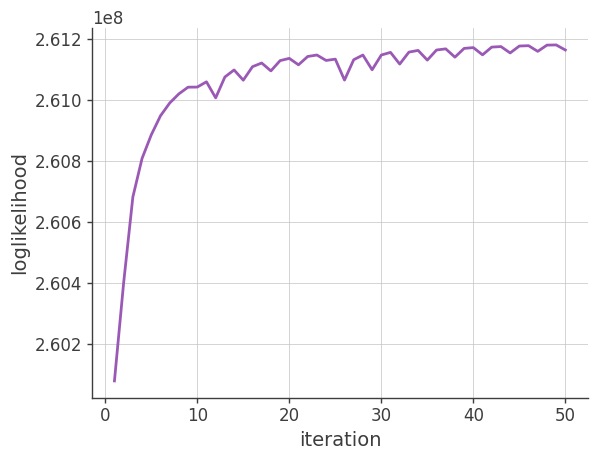

In [28]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['loglikelihood'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("loglikelihood")
plt.show()

## Alpha (the factor used for the acceleration)

Plotting $\alpha$ vs the number of iterations. $\alpha$ is a parameter to accelerate the EM algorithm (see the beginning of Section 4). If it is too large, reconstructed images may have artifacts.

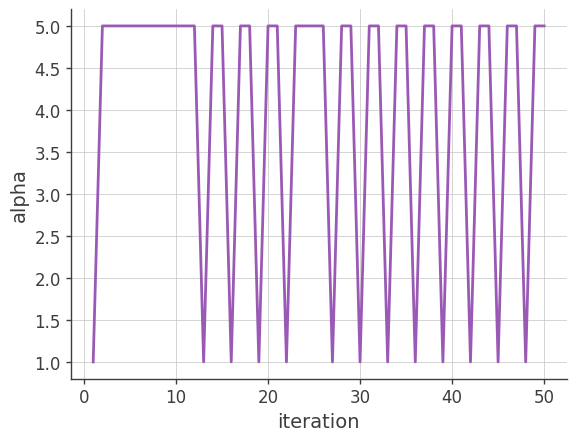

In [29]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['alpha'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("alpha")
plt.show()

## Background normalization

Plotting the background nomalization factor vs the number of iterations. If the backgroud model is accurate and the image is reconstructed perfectly, this factor should be close to 1.

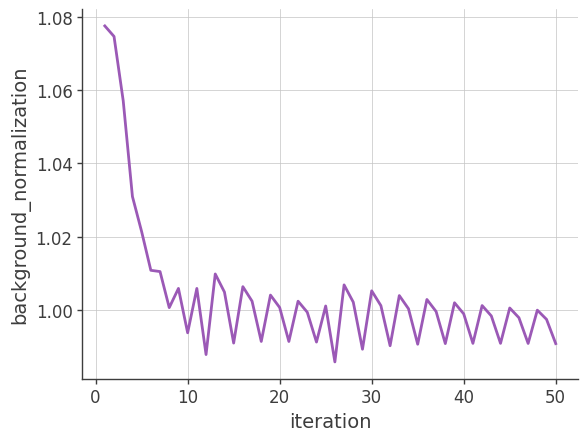

In [30]:
x, y = [], []

for result in all_results:
    x.append(result['iteration'])
    y.append(result['background_normalization'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("background_normalization")
plt.show()

## The reconstructed images

In [31]:
def plot_reconstructed_image(result, source_position = None): # source_position should be (l,b) in degrees
    iteration = result['iteration']
    image = result['model_map']

    for energy_index in range(image.axes['Ei'].nbins):
        map_healpxmap = HealpixMap(data = image[:,energy_index], unit = image.unit)

        _, ax = map_healpxmap.plot('mollview')        
        
        _.colorbar.set_label(str(image.unit))
        
        if source_position is not None:
            ax.scatter(source_position[0]*u.deg, source_position[1]*u.deg, transform=ax.get_transform('world'), color = 'red')

        plt.title(label = f"iteration = {iteration}, energy_index = {energy_index} ({image.axes['Ei'].bounds[energy_index][0]}-{image.axes['Ei'].bounds[energy_index][1]})")

Plotting the reconstructed images in all of the energy bands at the 50th iteration

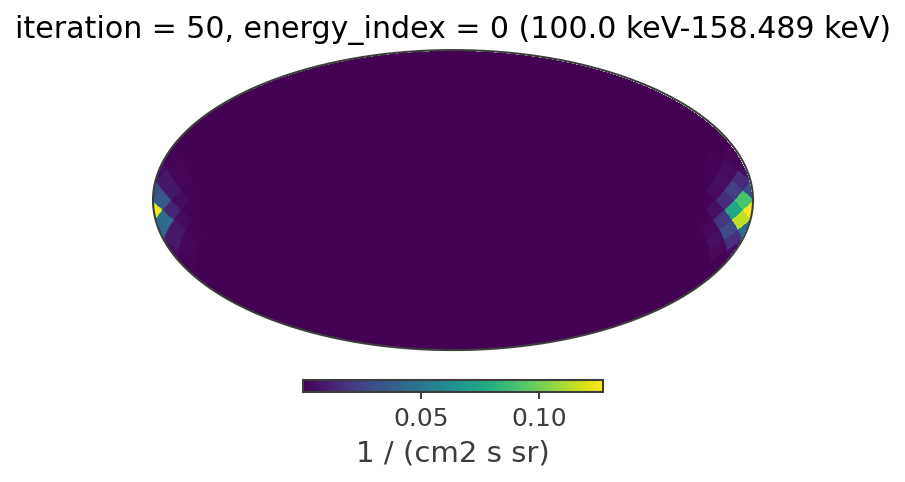

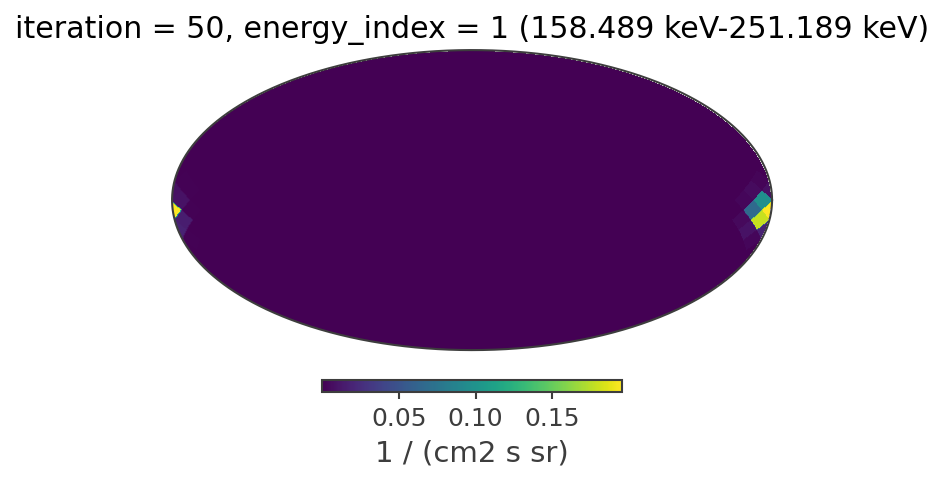

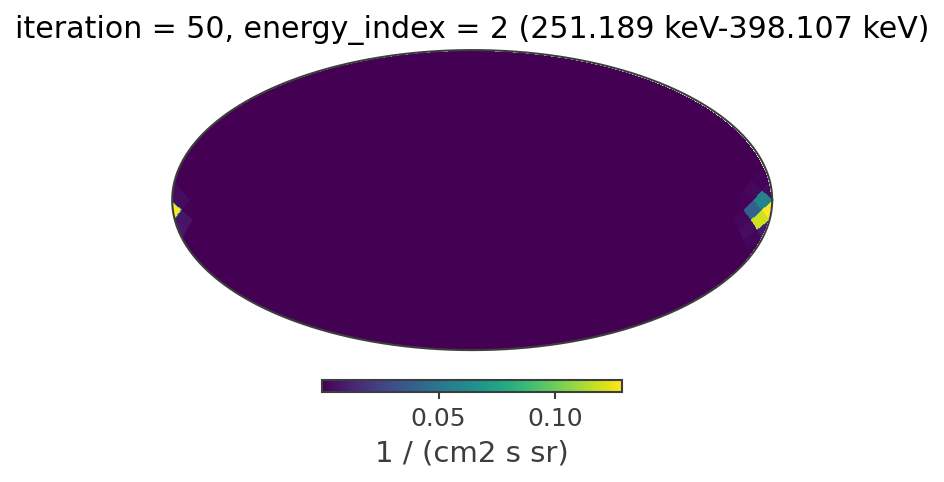

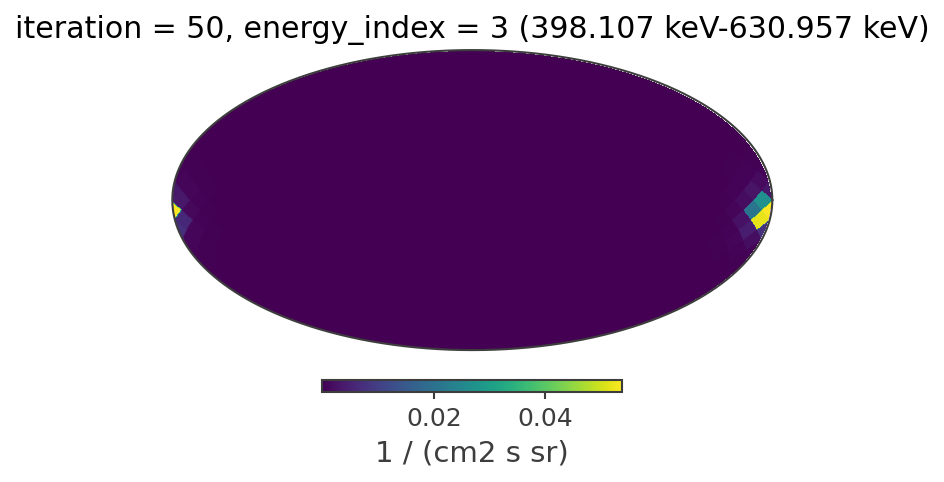

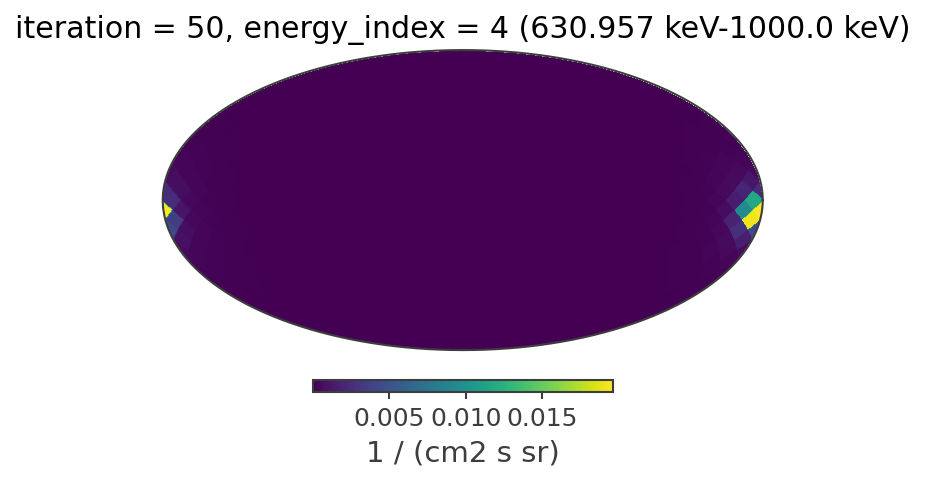

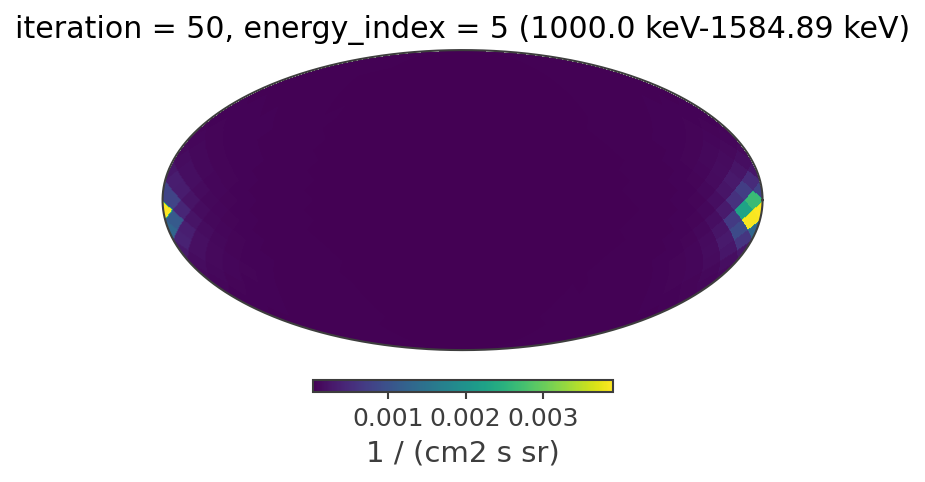

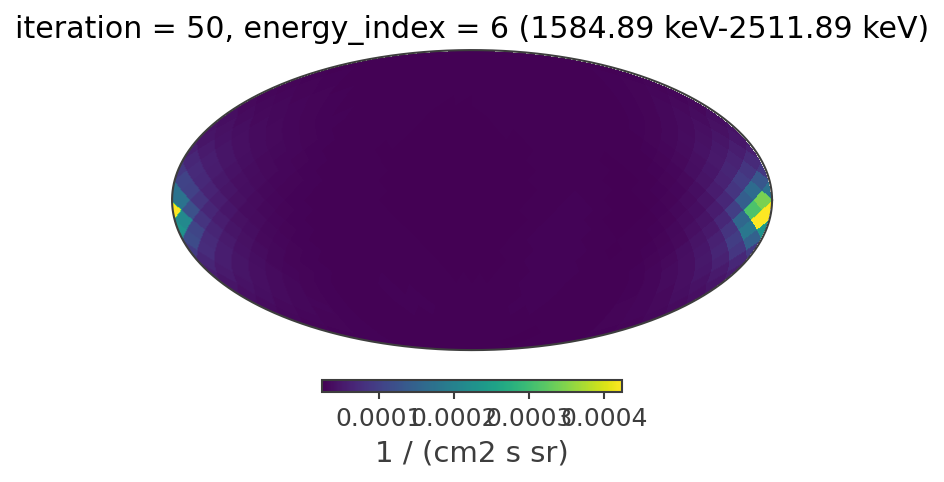

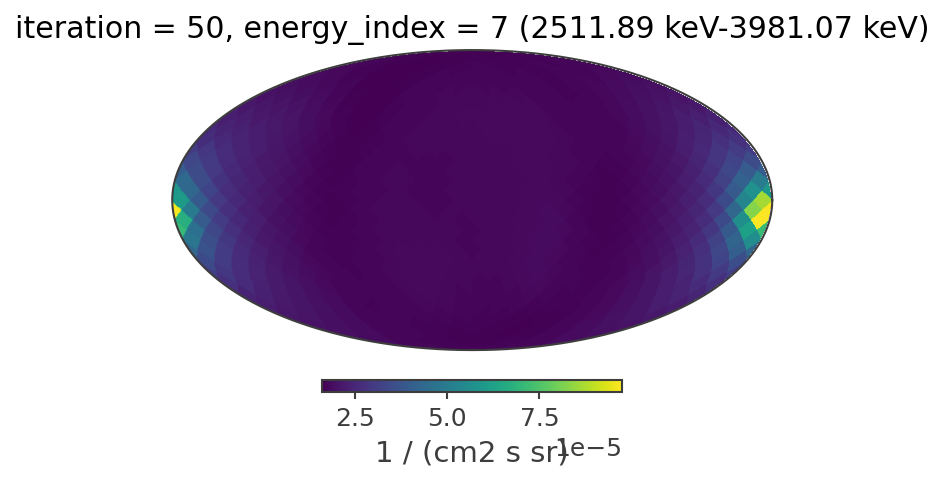

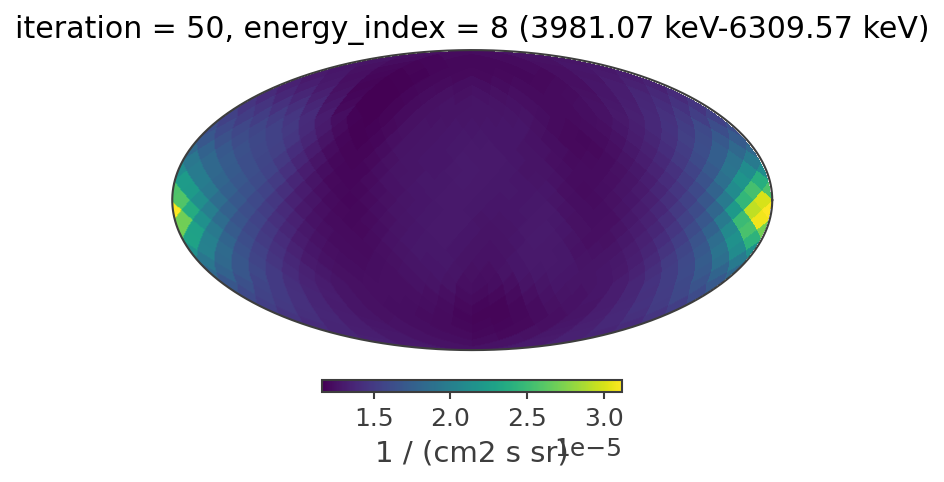

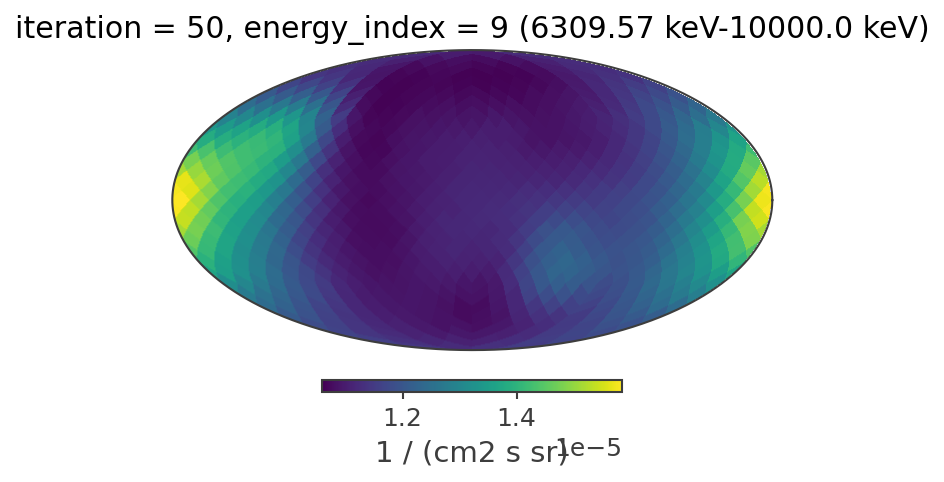

In [32]:
iteration = 49

plot_reconstructed_image(all_results[iteration])

## Integrated flux over the sky

Define the Crab spectral model

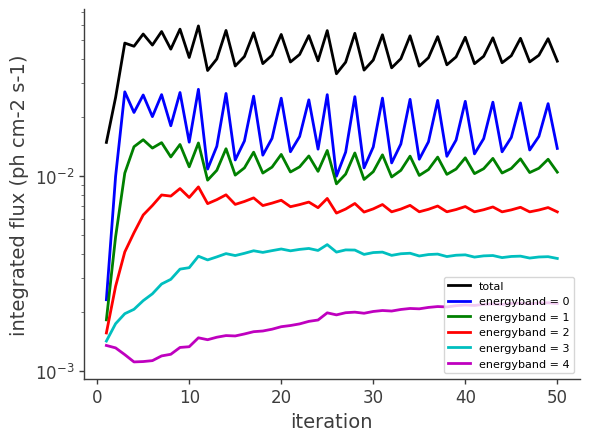

In [33]:
iteration = []
integrated_flux = []
integrated_flux_each_band = [[],[],[],[],[]]

for _ in all_results:
    iteration.append(_['iteration'])
    image = _['model_map']
    pixelarea = 4 * np.pi / image.axes['lb'].npix * u.sr

    integrated_flux.append(np.sum(image) * pixelarea)

    for energy_band in range(5):
        integrated_flux_each_band[energy_band].append(np.sum(image[:,energy_band]) * pixelarea)
                
plt.plot(iteration, [_.value for _ in integrated_flux], label = 'total', color = 'black')
plt.xlabel("iteration")
plt.ylabel("integrated flux (ph cm-2 s-1)")
plt.yscale("log")

colors = ['b', 'g', 'r', 'c', 'm']
for energy_band in range(5):
    plt.plot(iteration, [_.value for _ in integrated_flux_each_band[energy_band]], color = colors[energy_band], label = "energyband = {}".format(energy_band))

plt.legend()

## Spectrum

Plotting the gamma-ray spectrum at the 50th iteration. The photon flux at each energy band shown here is calculated as the accumulation of the flux values in all pixels at each energy band.

In [34]:
energy_truth = []
flux_truth = []

with open("crab_spec.dat", "r") as f:
    for line in f:
        data = line.split('\t')
        if data[0] == 'DP':
            energy_truth.append(float(data[1]))# * u.keV)
            flux_truth.append(float(data[2]))# / u.cm**2 / u.s / u.keV)

In [35]:
def get_differential_flux(model_map):
    pixelarea = 4 * np.pi / model_map.axes['lb'].npix * u.sr
        
    differential_flux = np.sum(model_map, axis = 0) * pixelarea / model_map.axes['Ei'].widths
    
    return differential_flux

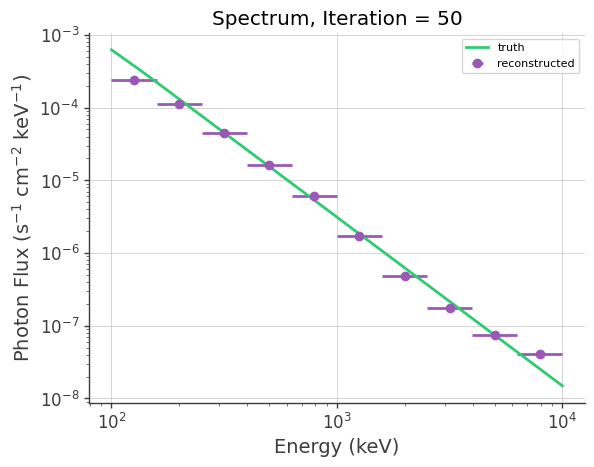

In [36]:
iteration = 49

result = all_results[iteration]

model_map = result['model_map']

differential_flux = get_differential_flux(model_map)

energy_band = model_map.axes['Ei'].centers

err_energy = model_map.axes['Ei'].bounds.T - model_map.axes['Ei'].centers
err_energy[0,:] *= -1
        
plt.errorbar(energy_band, differential_flux, xerr=err_energy, fmt='o', label = 'reconstructed')
plt.plot(energy_truth, flux_truth, label = 'truth')
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Energy (keV)")
plt.ylabel(r"Photon Flux (s$^{-1}$ cm$^{-2}$ keV$^{-1}$)")
plt.title(f"Spectrum, Iteration = {result['iteration']}")
plt.grid()
plt.legend()

## Plot All

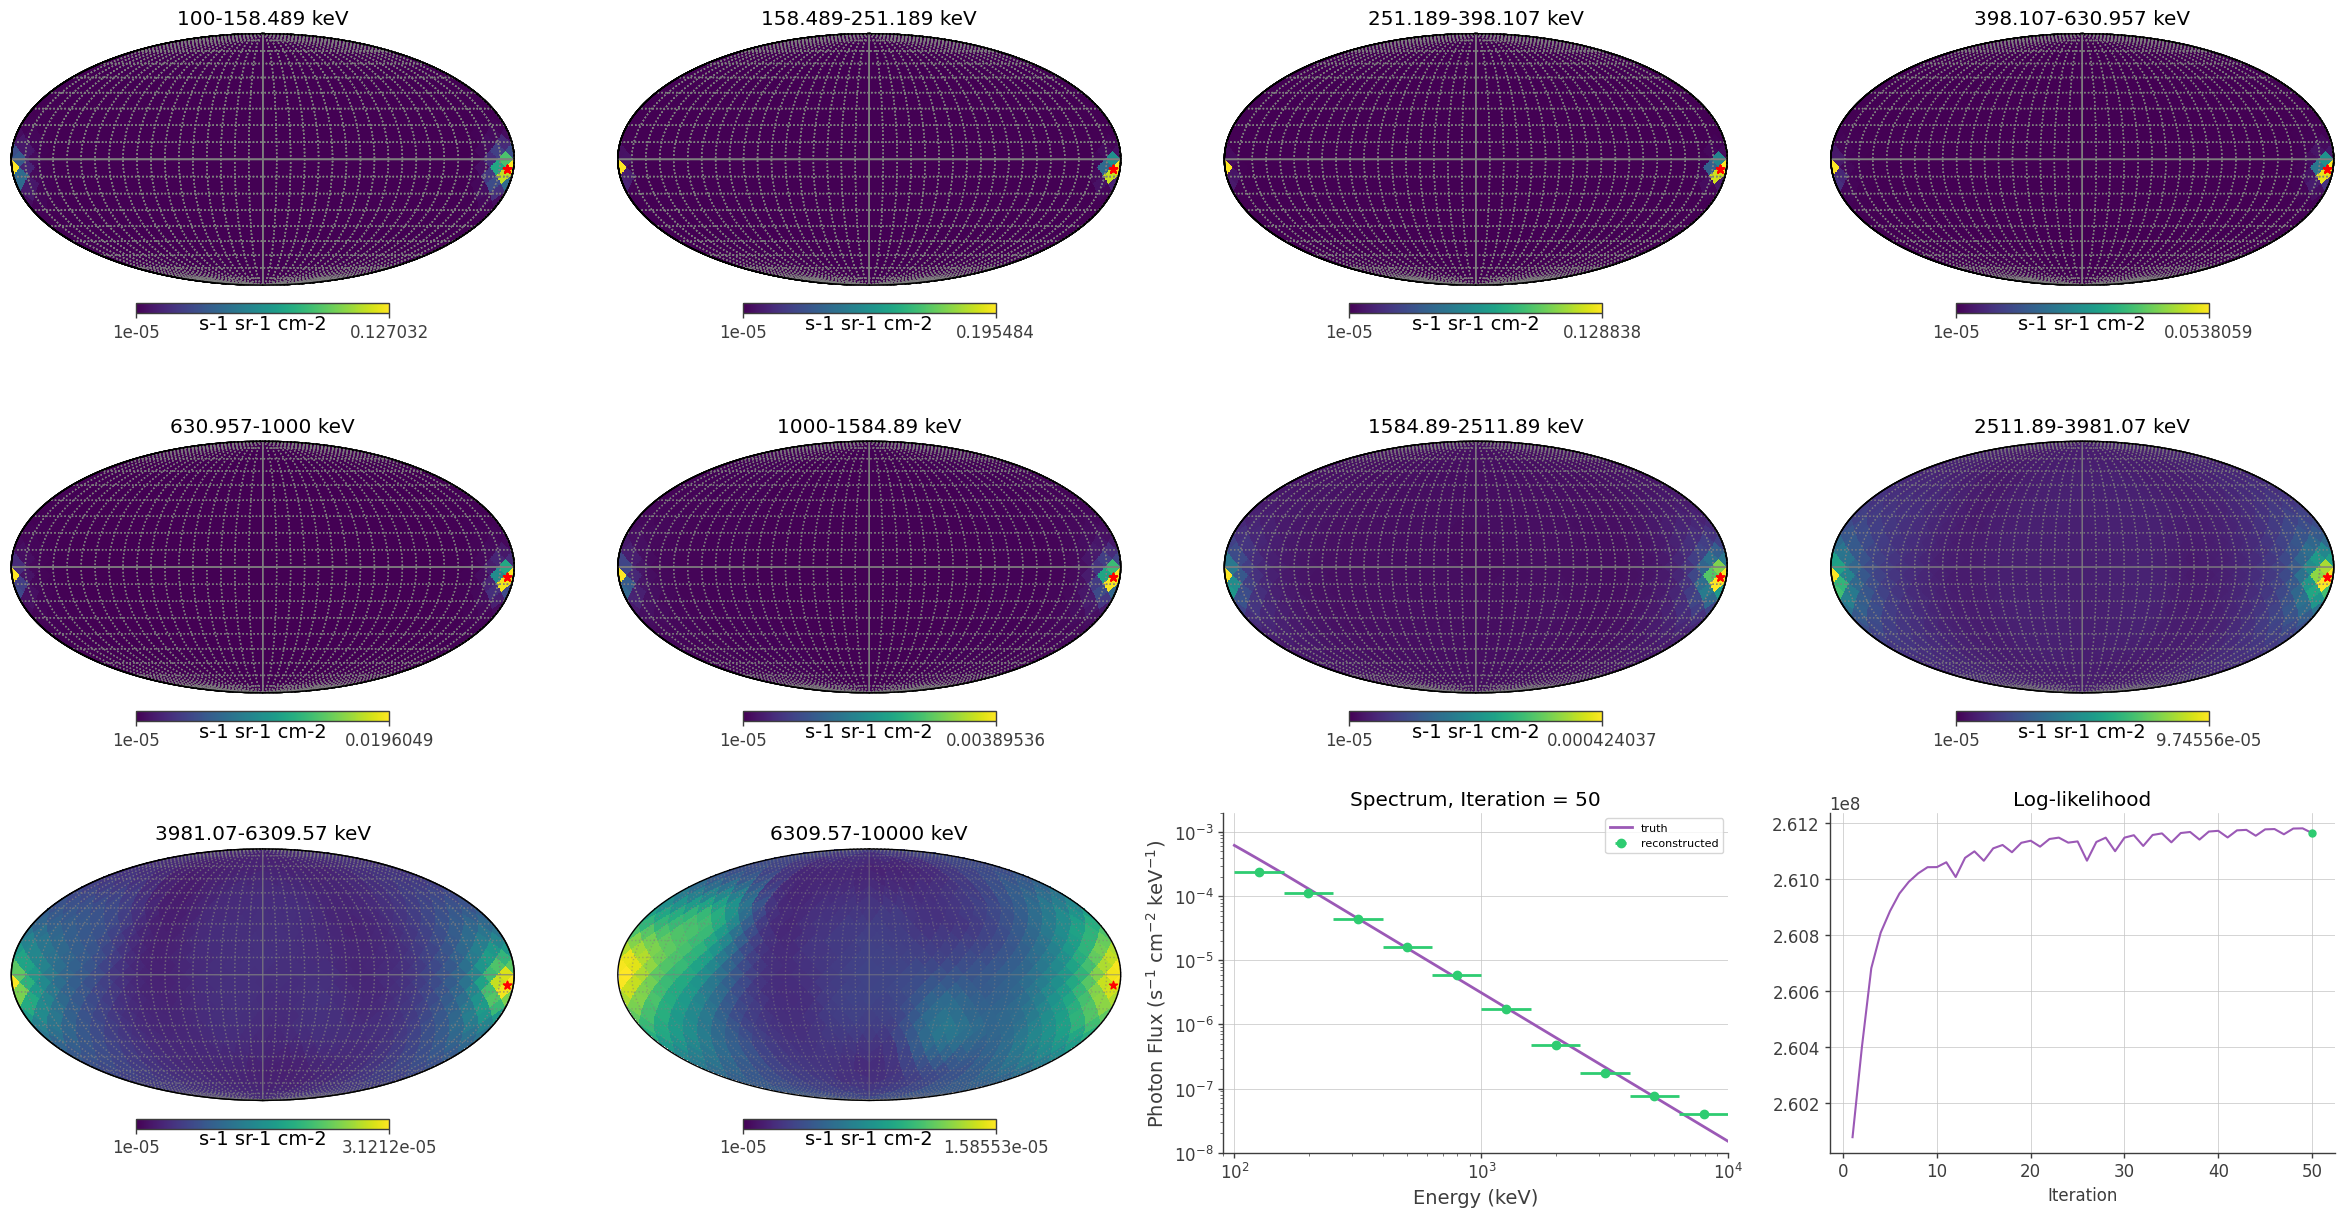

In [37]:
title = ["100-158.489 keV",
"158.489-251.189 keV", 
"251.189-398.107 keV", 
"398.107-630.957 keV", 
"630.957-1000 keV", 
"1000-1584.89 keV", 
"1584.89-2511.89 keV", 
"2511.89-3981.07 keV", 
"3981.07-6309.57 keV", 
"6309.57-10000 keV"]

position = {"l":184.600, "b": -5.800}

i_iteration = 49 # ==>50th iteration
th = -5

fig = plt.figure(figsize=(30, 15))
gs = GridSpec(nrows=3, ncols=4)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
ax7 = fig.add_subplot(gs[1, 3])
ax8 = fig.add_subplot(gs[2, 0])
ax9 = fig.add_subplot(gs[2, 1])

axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
    
ax_spectrum = fig.add_subplot(gs[2, 2])
ax_likelihood = fig.add_subplot(gs[2, 3])
#ax_background = fig.add_subplot(gs[1, 3])

#plt.subplots_adjust(wspace=0.4, hspace=0.5)

image = all_results[i_iteration]['model_map']

for i_energy in range(image.axes['Ei'].nbins):   
    plt.axes(axes[i_energy])

    data = image.contents[:,i_energy]
    data[data < 10**th * image.unit] = 10**th * image.unit

    hp.mollview(data, norm = 'liner', min = 10**th, title = title[i_energy], hold=True, unit = "s-1 sr-1 cm-2")
    hp.graticule(color='gray', dpar = 10, alpha = 0.5)
    hp.projscatter(theta = position["l"], phi = position["b"], lonlat = True, color = 'red', linewidths = 1, marker = "*")

###        
        
plt.axes(ax_spectrum)

energy_band = image.axes['Ei'].centers

err_energy = image.axes['Ei'].bounds.T - image.axes['Ei'].centers
err_energy[0,:] *= -1

differential_flux = get_differential_flux(image)
    
plt.plot(energy_truth, flux_truth, label = 'truth')

plt.errorbar(energy_band, differential_flux, xerr=err_energy, fmt='o', label = 'reconstructed')
plt.xscale("log")
plt.yscale("log")
plt.xlim(90, 10000)
plt.ylim(1e-8, 2e-3)
    
plt.xlabel("Energy (keV)")
plt.ylabel(r"Photon Flux (s$^{-1}$ cm$^{-2}$ keV$^{-1}$)")
plt.title(f"Spectrum, Iteration = {iteration+1}")
plt.grid()
plt.legend()
        
###        
        
plt.axes(ax_likelihood)

iterations = [_['iteration'] for _ in all_results]
loglikelihoods = [_['loglikelihood'] for _ in all_results]

plt.plot(iterations, loglikelihoods, linewidth = 1.5)
plt.plot([iterations[i_iteration]], [loglikelihoods[i_iteration]], markersize = 10, marker = ".")

plt.xlabel("Iteration", fontsize = 12)
plt.title("Log-likelihood")
plt.grid()

###
#    plt.axes(ax_background)

#    plt.plot(iterations, background_normalizations, linewidth = 1.5)
#    plt.plot([iterations[i]], [background_normalizations[i]], markersize = 10, marker = ".")

#    plt.xlabel("Iteration", fontsize = 12)
    #plt.ylabel("Background Normalization", fontsize = 12)
#    plt.ylim(0.7, 1.4)
#    plt.title("Background Normalization")
#    plt.grid()    

#    plt.savefig(f"fig_{i:03}.png")